In [1]:
!pip install cvt-tensorflow -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.8.2 requires keras-core, which is not installed.
keras-nlp 0.8.2 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
sqlalchemy 2.0.25 requires typing-extensions>=4.6.0, but you have typing-extensions 4.4.0 which is incompatible.
albumentations 1.4.0 requires numpy>=1.24.4, but you have numpy 1.23.1 which is incompatible.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 2.2.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.2 which is incompatible.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.5 which is incompatible.
c

In [2]:
#import non tensorflow libraries
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pathlib
import IPython.display as display

#import tensorflow libraries
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers as tfl
import pickle

In [3]:
from tensorflow import keras
import tensorflow as tf

In [4]:
from cvt_tensorflow import CvT

In [5]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
train_dataset = image_dataset_from_directory('/kaggle/input/preprocessing-koa-dataset-binary/train/',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory('/kaggle/input/preprocessing-koa-dataset-binary/val/',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 7304 files belonging to 2 classes.
Found 826 files belonging to 2 classes.


In [6]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.Resizing(224,224),
        tf.keras.layers.RandomFlip(mode="horizontal"),
        tf.keras.layers.RandomZoom(0.1)
    ])
    
    return data_augmentation

In [7]:
base_model = CvT(configuration="cvt-13", pretrained=True, pretrained_resolution=224,
    pretrained_version="1k", data_format="channels_last", classifier_activation="relu")
base_model.trainable = True

80634088/80634088 [==============================] - 2s 0us/step


In [8]:
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [9]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9), 
      loss = tf.keras.losses.BinaryCrossentropy(), 
      metrics=['accuracy',keras.metrics.AUC()])

In [10]:
epochs = 3

# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)

checkpoint_filepath = '/kaggle/working/checkpoint.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [11]:
class_weights = {0: 1.7345048682023272, 1: 2.3614613643711606}

In [12]:
history = model.fit(train_dataset,
                    class_weight = class_weights,
                    epochs=epochs,
                    validation_data = validation_dataset,
                    callbacks=[early_stopper, reduce_lr, model_checkpoint_callback])

Epoch 1/3
457/457 [==============================] - 10343s 23s/step - loss: 1.4113 - accuracy: 0.5435 - auc: 0.5542 - val_loss: 0.7082 - val_accuracy: 0.4806 - val_auc: 0.5558 - lr: 0.0010
Epoch 2/3
457/457 [==============================] - 10401s 23s/step - loss: 1.3382 - accuracy: 0.5987 - auc: 0.6193 - val_loss: 0.7283 - val_accuracy: 0.4879 - val_auc: 0.6774 - lr: 0.0010
Epoch 3/3
457/457 [==============================] - 10399s 23s/step - loss: 1.3084 - accuracy: 0.6150 - auc: 0.6464 - val_loss: 0.6959 - val_accuracy: 0.5169 - val_auc: 0.5752 - lr: 0.0010


In [13]:
model.save("saved.model.keras")
model.save_weights("cp.ckpt")

In [14]:
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [15]:
# use best model for validation and testing calculation of metrics
test_dataset = image_dataset_from_directory('/kaggle/input/preprocessing-koa-dataset-binary/test/',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1656 files belonging to 2 classes.


In [16]:
results = model.evaluate(test_dataset)
predictions = model.predict(test_dataset)

104/104 [==============================] - 804s 8s/step


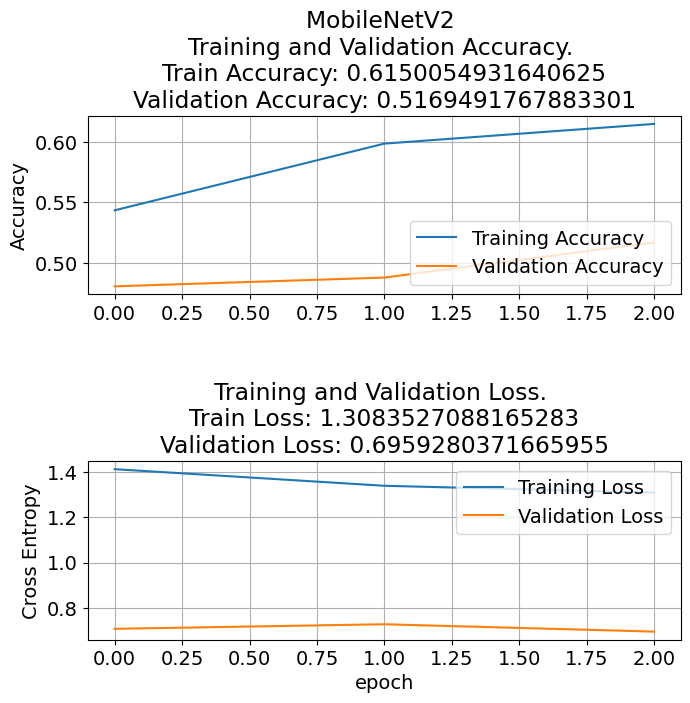

In [17]:
#get results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'MobileNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()